In [1]:
import torch
from torch import optim, nn, utils, Tensor
import lightning as L

import numpy as np
import matplotlib.pyplot as plt

from Network import Generator, Discriminator
from Signal_Generator import *
from Signal_Analyzer import *

from getdist import plots, MCSamples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
dataset = []

for i in range(16000):
    SG = Signal_Generator(num_sources=1, noise_amplitude=0)
    signals = SG.generating_signal()
    params = SG.printing_parameters()
    signal = signals['Signal'].values

    signal_tensor = torch.tensor(signal, dtype=torch.float).unsqueeze(0).to(device)
    params_tensor = torch.tensor(params, dtype=torch.float).to(device)

    dataset.append((signal_tensor, params_tensor))

train_loader = utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

num_latent_variables = 20
learning_rate = 1e-5

In [ ]:
class GAN():
    def __init__(self, dataset, num_latent_variables, lr):
        self.dataset = dataset
        self.num_latent_variables = num_latent_variables
        self.lr = lr

        # Networks
        self.generator = Generator(in_channels=1, num_latent_variables=num_latent_variables, length=len(signal), num_parameters=len(params)).to(device)
        self.discriminator = Discriminator(input_channels=1, length=len(signal), num_parameters=len(params)).to(device)
        self.criterion = nn.BCELoss()

        # Optimizers
        self.optimizer_g = optim.Adam(self.generator.parameters(), lr=self.lr)
        self.optimizer_d = optim.Adam(self.discriminator.parameters(), lr=self.lr)

    def adversarial_loss(self, output_d, y):
        return self.criterion(output_d, y)
    
    def train_generator(self, signal_tensor, z):
        generated_params = self.generator(signal_tensor, z)
        fake_output = self.discriminator(signal_tensor, generated_params)
        g_loss = self.adversarial_loss(fake_output, torch.ones_like(fake_output))

        self.optimizer_g.zero_grad()
        g_loss.backward()
        self.optimizer_g.step()

        return g_loss.item()
    
    def train_discriminator(self, signal_tensor, params_tensor, z):
        fake_params = self.generator(signal_tensor, z).detach()
        real_output = self.discriminator(signal_tensor, params_tensor)
        fake_output = self.discriminator(signal_tensor, fake_params)

        real_loss = self.adversarial_loss(real_output, torch.ones_like(real_output))
        fake_loss = self.adversarial_loss(fake_output, torch.zeros_like(fake_output))
        d_loss = (real_loss + fake_loss) / 2
        self.optimizer_d.zero_grad()
        d_loss.backward()
        self.optimizer_d.step()

        return d_loss.item()

In [ ]:
gan = GAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate)

d_loss_list = []
# Train the GAN
for i in range(200):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        d_loss = gan.train_discriminator(signal_tensor, params_tensor, z)
        d_loss_list.append(d_loss)
    #print(f"Epoch {i}, Discriminator loss: {d_loss}")

In [ ]:
plt.plot(d_loss_list)
plt.yscale('log')

In [ ]:
gan = GAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate)

g_loss_list = []
# Train the GAN
for i in range(10):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        g_loss = gan.train_generator(signal_tensor, z)
        g_loss_list.append(g_loss)
    #print(f"Epoch {i}, Discriminator loss: {g_loss}")

In [ ]:
plt.plot(g_loss_list)
#plt.yscale('log')

In [ ]:
gan = GAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate)
g_loss_list = []
d_loss_list = []

num_epochs = 50
num_discriminator = 3
num_generator = 3

for epoch in range(num_epochs):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)

        for _ in range(num_discriminator):
            g_loss = gan.train_generator(signal_tensor, z)
            g_loss_list.append(g_loss)

        for _ in range(num_generator):
            d_loss = gan.train_discriminator(signal_tensor, params_tensor, z)
            d_loss_list.append(d_loss)
    print(f"Epoch {epoch}, Generator loss: {g_loss}, Discriminator loss: {d_loss}")

In [ ]:
generator = gan.generator
generator.eval()

for i in range(10):
    TS = Signal_Generator(num_sources=1, noise_amplitude=1)
    test_data = TS.generating_signal()
    params = TS.printing_parameters()

    input_signal = test_data['Signal'].values
    input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        generated_params = generator(input_signal_tensor, z).squeeze().cpu().numpy()

    print(params)
    print(generated_params)

In [3]:
class WGAN():
    def __init__(self, dataset, num_latent_variables, lr, weight_clip):
        self.dataset = dataset
        self.num_latent_variables = num_latent_variables
        self.lr = lr
        self.weight_clip = weight_clip

        # Networks
        self.generator = Generator(in_channels=1, num_latent_variables=num_latent_variables, length=len(signal), num_parameters=len(params)).to(device)
        self.discriminator = Discriminator(input_channels=1, length=len(signal), num_parameters=len(params)).to(device)

        # Optimizers
        self.optimizer_g = optim.Adam(self.generator.parameters(), lr=self.lr)
        self.optimizer_d = optim.Adam(self.discriminator.parameters(), lr=self.lr)

    def wasserstein_loss(self, output_d, y):
        return torch.mean(output_d * y)
    
    def train_generator(self, signal_tensor, params_tensor, z):
        fake_params = self.generator(signal_tensor, z)
        fake_output = self.discriminator(signal_tensor, fake_params)
        real_output = self.discriminator(signal_tensor, params_tensor)
        g_loss = -torch.mean(fake_output)
        d_loss = -(torch.mean(real_output) - torch.mean(fake_output))

        self.optimizer_g.zero_grad()
        g_loss.backward()
        self.optimizer_g.step()

        return g_loss.item(), d_loss.item()
    
    def train_discriminator(self, signal_tensor, params_tensor, z):
        fake_params = self.generator(signal_tensor, z)
        fake_output = self.discriminator(signal_tensor, fake_params)
        real_output = self.discriminator(signal_tensor, params_tensor)
        g_loss = -torch.mean(fake_output)
        d_loss = -(torch.mean(real_output) - torch.mean(fake_output))

        self.optimizer_d.zero_grad()
        d_loss.backward()
        self.optimizer_d.step()

        # Weight clipping
        for p in self.discriminator.parameters():
            p.data.clamp_(-self.weight_clip, self.weight_clip)

        return g_loss.item(), d_loss.item()

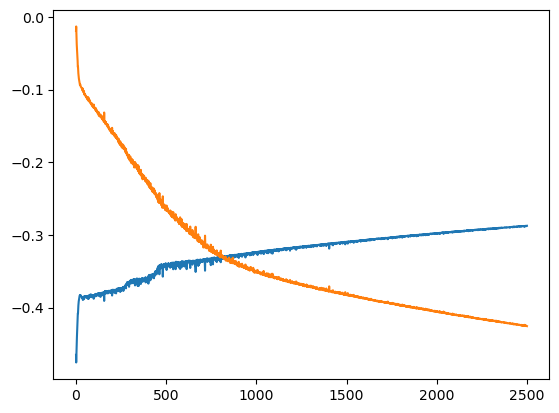

In [24]:
wgan = WGAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate, weight_clip=0.1)

loss_list = []
# Train the GAN
for i in range(20):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        loss = wgan.train_discriminator(signal_tensor, params_tensor, z)
        loss_list.append(loss)
    #print(f"Epoch {i}, Discriminator loss: {d_loss}")

plt.plot(loss_list)

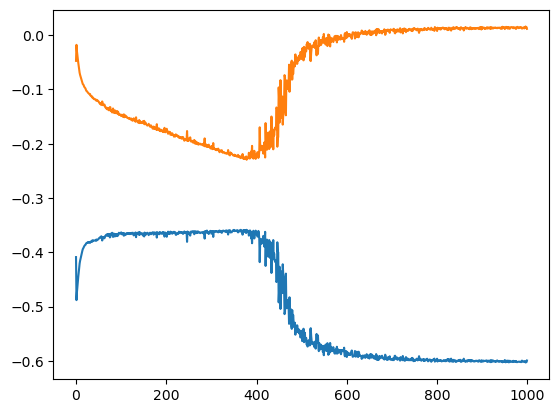

In [6]:
wgan = WGAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate, weight_clip=0.1)

loss_list = []
for i in range(3):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        loss = wgan.train_discriminator(signal_tensor, params_tensor, z)
        loss_list.append(loss)

for i in range(5):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        loss = wgan.train_generator(signal_tensor, params_tensor, z)
        loss_list.append(loss)
    #print(f"Epoch {i}, Discriminator loss: {g_loss}")

plt.plot(loss_list)

Epoch 1/100, Generator loss: -0.3532097637653351, Discriminator loss: -0.24273386597633362
Epoch 2/100, Generator loss: -0.4242474138736725, Discriminator loss: -0.21430286765098572
Epoch 3/100, Generator loss: -0.5472216606140137, Discriminator loss: -0.10421872138977051
Epoch 4/100, Generator loss: -0.523637592792511, Discriminator loss: -0.12305182218551636
Epoch 5/100, Generator loss: -0.45409703254699707, Discriminator loss: -0.17772966623306274
Epoch 6/100, Generator loss: -0.5266222953796387, Discriminator loss: -0.09947013854980469
Epoch 7/100, Generator loss: -0.45028358697891235, Discriminator loss: -0.16053014993667603
Epoch 8/100, Generator loss: -0.4723757803440094, Discriminator loss: -0.13727590441703796
Epoch 9/100, Generator loss: -0.47993993759155273, Discriminator loss: -0.11388325691223145
Epoch 10/100, Generator loss: -0.4831521511077881, Discriminator loss: -0.11571025848388672
Epoch 11/100, Generator loss: -0.4915764033794403, Discriminator loss: -0.1221198141574

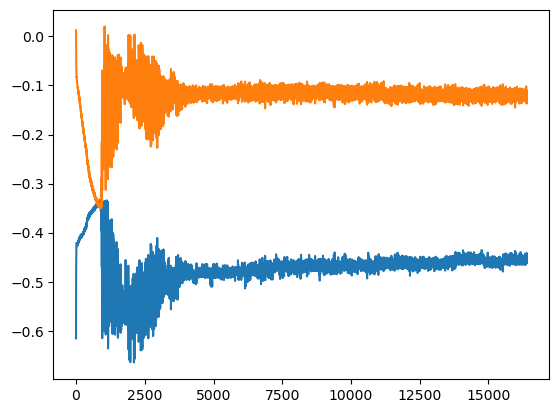

In [46]:
wgan = WGAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate, weight_clip=0.1)

loss_list = []
d_loss_threshold = -0.1

num_epochs = 100
num_discriminator = 10

for i in range(7):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        loss = wgan.train_discriminator(signal_tensor, params_tensor, z)
        loss_list.append(loss) 

for epoch in range(num_epochs):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        signal_tensor = signal_tensor.to(device)
        params_tensor = params_tensor.to(device)
        
        if loss_list[-1][1] < d_loss_threshold:
            loss = wgan.train_generator(signal_tensor, params_tensor, z)
            loss_list.append(loss)
        elif loss_list[-1][0] >= d_loss_threshold:
            for _ in range(num_discriminator):
                loss = wgan.train_discriminator(signal_tensor, params_tensor, z)
                loss_list.append(loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Generator loss: {loss[0]}, Discriminator loss: {loss[1]}")

plt.plot(loss_list)

In [47]:
generator = wgan.generator
generator.eval()

generated_params_list = []

TS = Signal_Generator(num_sources=1, noise_amplitude=1)
test_data = TS.generating_signal()
params = TS.printing_parameters()

input_signal = test_data['Signal'].values
input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)

for i in range(10000):
    with torch.no_grad():
        z = torch.randn(1, num_latent_variables, 1).to(device)
        generated_params = generator(input_signal_tensor, z).squeeze().cpu().numpy()

    generated_params_list.append(generated_params)

Removed no burn in


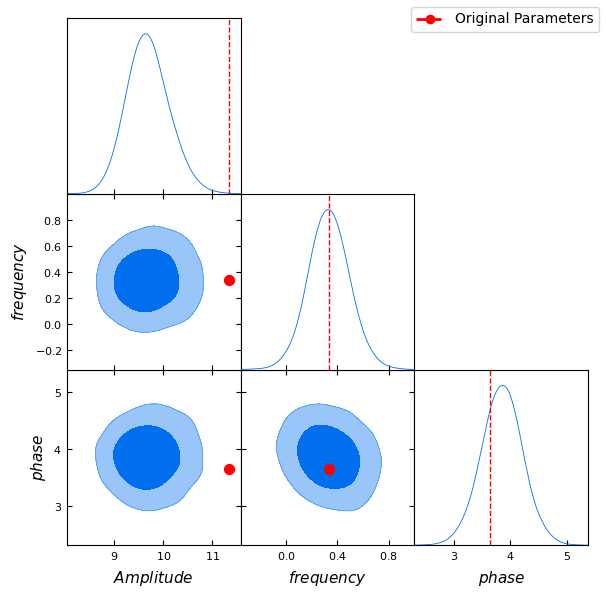

In [48]:
generated_params_df = pd.DataFrame(generated_params_list, columns=['Amplitude', 'Frequency', 'Phase'])


names = ["A","omega","theta"]
labels =  ["Amplitude","frequency","phase"]

generated_params_samples = MCSamples(samples=generated_params_df.values, names=names, labels=labels)
#samples.setRanges([[-3,3],[-3,3]])
generated_params_samples.updateSettings({'fine_bins_2D': 1048})

g = plots.get_subplot_plotter()

g.triangle_plot([generated_params_samples], filled=True)

axes = g.subplots

for i in range(len(names)):
    for j in range(i+1, len(names)):
        ax = axes[j, i]
        if ax is not None:
            ax.scatter(params[i], params[j], color='red', marker='o', s=50)

for i in range(len(names)):
    ax = axes[i, i]
    if ax is not None:
        ax.axvline(params[i], linestyle='--', color='red', lw=1)

handles = [plt.Line2D([0], [0], color='red', lw=2, linestyle='--', marker='o')]
labels = ['Original Parameters']
g.fig.legend(handles, labels, loc='upper right')

plt.show()
#g.export('weight_clip_0.1for300epochs.png')

In [49]:
params

[11.34518472945435, 0.33848254991856946, 3.6408947040065494]

In [50]:
generated_params_list

[array([9.665057 , 0.6185245, 3.2932982], dtype=float32),
 array([9.490052 , 0.4136545, 4.0523453], dtype=float32),
 array([9.927826  , 0.42503175, 3.6914067 ], dtype=float32),
 array([9.927489  , 0.08781869, 3.616333  ], dtype=float32),
 array([9.717614 , 0.7025712, 3.3058927], dtype=float32),
 array([10.094138 ,  0.4596937,  4.0740504], dtype=float32),
 array([9.337211 , 0.5658767, 3.6974773], dtype=float32),
 array([9.605353  , 0.47903764, 3.7990918 ], dtype=float32),
 array([9.9040165, 0.3242124, 3.724805 ], dtype=float32),
 array([9.775017  , 0.67254204, 3.8459182 ], dtype=float32),
 array([10.935026 ,  0.4875304,  4.77608  ], dtype=float32),
 array([10.034593  ,  0.18556684,  3.509253  ], dtype=float32),
 array([9.280851 , 0.3588432, 4.067012 ], dtype=float32),
 array([9.000285  , 0.25351068, 4.06294   ], dtype=float32),
 array([10.273036  ,  0.23609063,  3.224419  ], dtype=float32),
 array([9.673732 , 0.5094979, 3.4957914], dtype=float32),
 array([9.954237  , 0.17318922, 3.67847

In [51]:
generator = wgan.generator
generator.eval()

prams_list = []
generated_params_list = []

for i in range(20):
    TS = Signal_Generator(num_sources=1, noise_amplitude=1)
    test_data = TS.generating_signal()
    params = TS.printing_parameters()

    input_signal = test_data['Signal'].values
    input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        z = torch.randn(1, num_latent_variables, 1).to(device)
        generated_params = generator(input_signal_tensor, z).squeeze().cpu().numpy()

    prams_list.append(params)
    generated_params_list.append(generated_params)

    print(params)
    print(generated_params)

[9.49032565441339, 0.3463304580677724, 4.747602309399006]
[9.600061   0.43427053 4.7318206 ]
[9.684774163094097, 0.36711794449835045, 1.3379182755530319]
[9.9334612e+00 8.1899585e-03 1.8322890e+00]
[9.566603377639941, 0.3021955001735305, 1.6554619430341204]
[9.840625   0.08001255 2.1317601 ]
[12.086648044820326, 0.30004987416700113, 6.251699729624828]
[9.853877   0.39187497 4.6583114 ]
[9.81427129967572, 0.4024925520381699, 4.991932390505219]
[9.631673  0.4677861 5.3222795]
[10.589576593953556, 0.3988928106442384, 5.15937571323696]
[9.44501   0.4853829 5.1590304]
[10.616745626882878, 0.2705413811490757, 0.29900033907502593]
[9.353059   0.21762954 1.715549  ]
[8.92692433588441, 0.31932580019408496, 3.0480729113233593]
[9.946248   0.38937476 2.9135652 ]
[10.276155178103583, 0.3421681226732141, 3.3485772181964015]
[9.718376   0.19296916 4.068284  ]
[11.453374637150644, 0.30992238705491865, 5.733928225437184]
[9.919062   0.36866012 4.831943  ]
[11.54810637554672, 0.2926941906544506, 5.1561

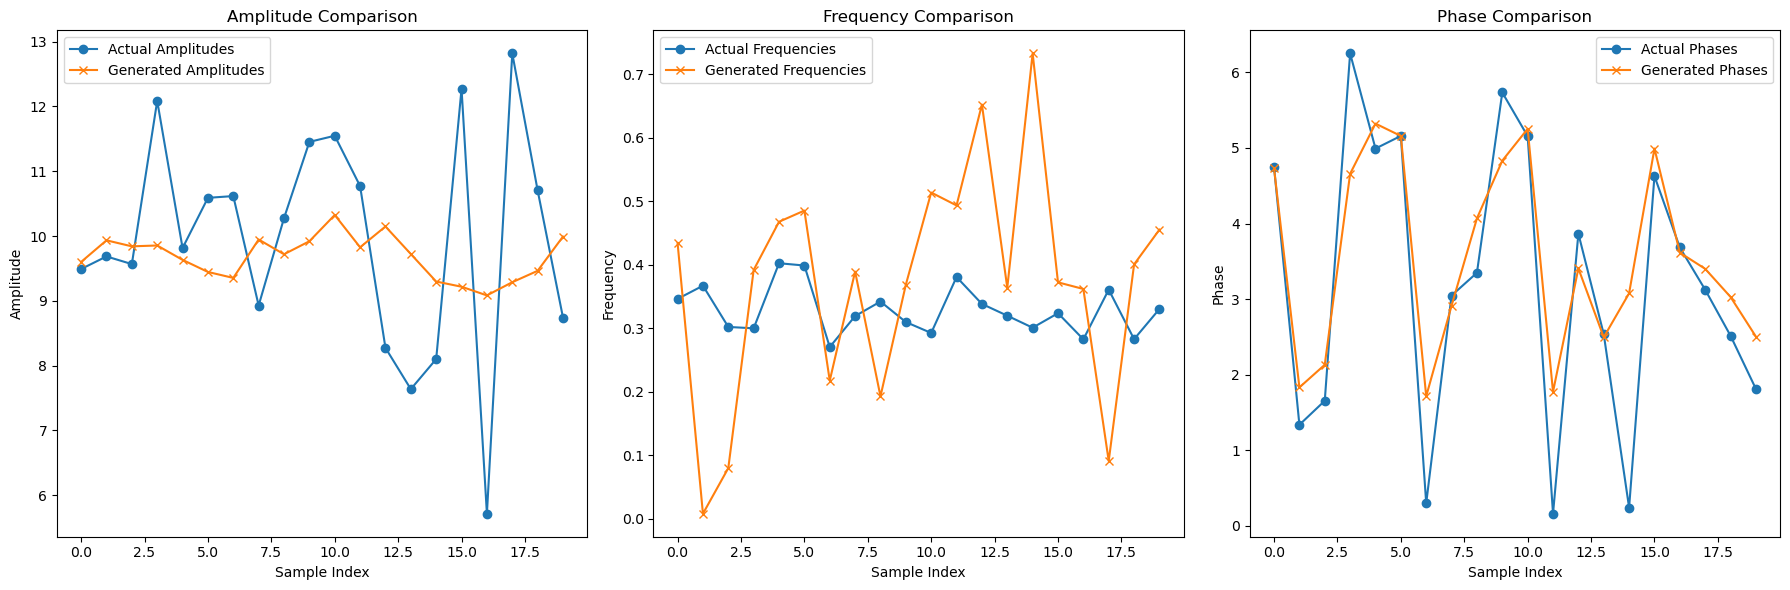

: 

In [52]:
actual_amplitudes = [params[0] for params in prams_list]
actual_frequencies = [params[1] for params in prams_list]
actual_phases = [params[2] for params in prams_list]

generated_amplitudes = [gen_params[0] for gen_params in generated_params_list]
generated_frequencies = [gen_params[1] for gen_params in generated_params_list]
generated_phases = [gen_params[2] for gen_params in generated_params_list]

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(range(20), actual_amplitudes, 'o-', label='Actual Amplitudes')
plt.plot(range(20), generated_amplitudes, 'x-', label='Generated Amplitudes')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Amplitude Comparison')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(20), actual_frequencies, 'o-', label='Actual Frequencies')
plt.plot(range(20), generated_frequencies, 'x-', label='Generated Frequencies')
plt.xlabel('Sample Index')
plt.ylabel('Frequency')
plt.title('Frequency Comparison')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(20), actual_phases, 'o-', label='Actual Phases')
plt.plot(range(20), generated_phases, 'x-', label='Generated Phases')
plt.xlabel('Sample Index')
plt.ylabel('Phase')
plt.title('Phase Comparison')
plt.legend()

plt.tight_layout()
plt.show()
